In [1]:
import pandas as pd

df01 = pd.read_csv(r'data/990001.csv',sep=';', names=['Num','X','Y','Dist'])
df01

,Num,X,Y,Dist
0,6a,132.0273,105.5994,48.286822
1,6,106.5573,104.7235,72.991942
2,7,140.6679,108.2610,39.255562
3,8,167.3911,121.9081,10.148766
4,7a,152.7813,117.7490,25.075741
5,7b,155.1098,112.1205,24.402639
6,9001,100.0000,100.0000,0.000000


In [2]:
df02 = pd.read_csv(r'data/990002.csv',sep=';', names=['Num','X','Y','Dist'])
df02

,Num,X,Y,Dist
0,6a,147.0338,84.9535,32.513093
1,6,124.3194,73.3954,8.081438
2,7,153.7402,91.0169,41.498460
3,8,172.1918,114.6797,70.862721
4,7a,160.7087,104.7360,55.685659
5,7b,165.1976,100.6186,56.426914
6,9002,181.4615,118.8113,0.000000


Дополнительный шаг - выборка номер одинаковых номеров пунктов.
Сортирую номера и записи в таблицы, надеюсь, что принцип сортировки и в сете и в дф одинаковые, но лучше будет убедиться.

In [3]:
inter = sorted(set(list(zip(*df01['Num'].iteritems()))[1]).intersection(set(list(zip(*df02['Num'].iteritems()))[1])))

df01_com = df01.loc[df01['Num'].isin(inter)].sort_values(by='Num')
df02_com = df02.loc[df02['Num'].isin(inter)].sort_values(by='Num')

Создаю по два набора точек - mp01,mp02 - все точки, включая стоянки. mp01_c, mp02_c - набор общих точек.

In [4]:
from shapely.geometry import MultiPoint

mp01 = MultiPoint([i[2:4] for i in df01.itertuples()])
mp01_c = MultiPoint([i[2:4] for i in df01_com.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_com.itertuples()])

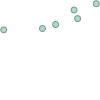

In [5]:
mp01_c

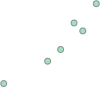

In [6]:
mp02_c

In [7]:
from shapely import affinity
from scipy.optimize import minimize

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

In [8]:
x0 = (0,0,0)

re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')

re

     fun: 0.0019267370659772987
     jac: array([ 0.5593133 ,  0.16264231,  0.27411119,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 213
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([-37.13354239,  90.74529647, -25.00025258])

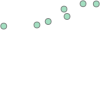

In [19]:
ar = re.x

mp_moved = mov(*ar,mp02)
mp_moved

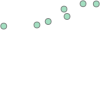

In [18]:
mp_moved = mov(-37.1335426 ,  90.74529586, -25.00025255,mp02)
mp_moved

Считаем расстояния от стоянки 99002 до всех точек.  
До сдвижки, после сдвижки, значение сдвижки.

In [10]:
dist_do = [mp02[-1].distance(i) for i in mp02]
dist_po = [mp_moved[-1].distance(i) for i in mp_moved]
od = zip(dist_do,dist_po)
od = [[i[0],i[1],i[0]-i[1]] for i in od]
df_od = pd.DataFrame.from_records(od,columns=('Before','After','Diff'))
df_od

,Before,After,Diff
0,48.286822,48.286822,2.842171e-14
1,72.991942,72.991942,0.000000e+00
2,39.255562,39.255562,2.842171e-14
3,10.148766,10.148766,8.881784e-15
4,25.075741,25.075741,3.552714e-14
5,24.402639,24.402639,3.552714e-14
6,0.000000,0.000000,0.000000e+00


Расстояние между всеми точками:

In [11]:
all_l = []
for origin in mp02:
    nap = []
    for p in mp02:
        nap.append(origin.distance(p))
    all_l.append(nap)

all_2 = []
for origin in mp_moved:
    nap = []
    for p in mp_moved:
        nap.append(origin.distance(p))
    all_2.append(nap)

all_a = [list(zip(i[0],i[1])) for i in list(zip(all_l,all_2))]
all_a

[[(0.0, 0.0),
  (25.485949913040336, 25.485949913040358),
  (9.041051958704786, 9.04105195870479),
  (38.943188498632196, 38.94318849863217),
  (24.048912579574143, 24.04891257957415),
  (23.985808063311087, 23.985808063311094),
  (48.286821681800504, 48.286821681800475)],
 [(25.485949913040336, 25.485949913040358),
  (0.0, 0.0),
  (34.29432511203566, 34.29432511203568),
  (63.21518890464538, 63.21518890464538),
  (48.02514302789738, 48.02514302789741),
  (49.11343862406704, 49.113438624067065),
  (72.9919417827749, 72.9919417827749)],
 [(9.041051958704786, 9.04105195870479),
  (34.29432511203566, 34.29432511203568),
  (0.0, 0.0),
  (30.006493403928424, 30.006493403928395),
  (15.38745258514222, 15.387452585142224),
  (14.948734315988094, 14.9487343159881),
  (39.255561963242876, 39.25556196324285)],
 [(38.943188498632196, 38.94318849863217),
  (63.21518890464538, 63.21518890464538),
  (30.006493403928424, 30.006493403928395),
  (0.0, 0.0),
  (15.190087402645188, 15.190087402645158),
 

Таблица с координатам сдвинутого 99002:

In [39]:
df2_nums = list(zip(*df02['Num'].iteritems()))[1]
al = list(zip(df2_nums,mp_moved.geoms))
mov_stag = [[i[0],i[1].x,i[1].y,al[-1][1].distance(i[1])] for i in al]
mov_df = pd.DataFrame.from_records(mov_stag,columns=('Num','X','Y','Dist'))
mov_df



,Num,X,Y,Dist
0,6a,132.027301,105.599400,48.286822
1,6,106.556396,104.723836,72.991942
2,7,140.667879,108.260421,39.255562
3,8,167.391099,121.908100,10.148766
4,7a,152.781469,117.749080,25.075741
5,7b,155.109681,112.120347,24.402639
6,9002,177.538390,121.735012,0.000000


Координаты 99001:

In [40]:
df01

,Num,X,Y,Dist
0,6a,132.0273,105.5994,48.286822
1,6,106.5573,104.7235,72.991942
2,7,140.6679,108.2610,39.255562
3,8,167.3911,121.9081,10.148766
4,7a,152.7813,117.7490,25.075741
5,7b,155.1098,112.1205,24.402639
6,9001,100.0000,100.0000,0.000000


Оригинальные координаты 990002:

In [41]:
df02

,Num,X,Y,Dist
0,6a,147.0338,84.9535,32.513093
1,6,124.3194,73.3954,8.081438
2,7,153.7402,91.0169,41.498460
3,8,172.1918,114.6797,70.862721
4,7a,160.7087,104.7360,55.685659
5,7b,165.1976,100.6186,56.426914
6,9002,181.4615,118.8113,0.000000


In [50]:
df_stag = zip(df01.itertuples(),mov_df.itertuples())
list(df_stag)
staging = [[i[0][0],i[0][1],i[0][2],i[1][2],i[0][2]-i[1][2],i[0][3],i[1][3],i[0][3]-i[1][3],i[0][4],i[1][4],i[0][4]-i[1][4]] for i in list(df_stag)]

In [49]:
staged_df = pd.DataFrame.from_records(staging,columns=('Ind','Num','X01','X02_m','X_dist','Y01','Y02_m','Y_dist','Dist_01','Dist_02','Dist_dist'),index='Ind')
staged_df

,Num,X01,X02_m,X_dist,Y01,Y02_m,Y_dist,Dist_01,Dist_02,Dist_dist
Ind,,,,,,,,,,
0,6a,132.0273,132.027301,-1.272372e-06,105.5994,105.599400,1.590450e-07,48.286822,48.286822,-1.800473e-09
1,6,106.5573,106.556396,9.043161e-04,104.7235,104.723836,-3.363235e-04,72.991942,72.991942,-2.774897e-09
2,7,140.6679,140.667879,2.088700e-05,108.2610,108.260421,5.787198e-04,39.255562,39.255562,-3.242846e-09
3,8,167.3911,167.391099,5.628970e-07,121.9081,121.908100,-2.736738e-07,10.148766,10.148766,-2.457712e-09
4,7a,152.7813,152.781469,-1.689461e-04,117.7490,117.749080,-7.968983e-05,25.075741,25.075741,4.851913e-09
5,7b,155.1098,155.109681,1.192700e-04,112.1205,112.120347,1.533701e-04,24.402639,24.402639,-2.367528e-11
6,9001,100.0000,177.538390,-7.753839e+01,100.0000,121.735012,-2.173501e+01,0.000000,0.000000,0.000000e+00


In [23]:
import os
import pandas as pd
from shapely import affinity
from shapely.geometry import MultiPoint
from scipy.optimize import minimize

def mov(x,y,angle,geom):
    geom_r = affinity.rotate(geom,angle,origin=(0,0))
    geom_t = affinity.translate(geom_r,x,y)
    return geom_t

def calc_dist(geom1,geom2):
    dist = 0
    geom_list = zip(geom1,geom2)
    for item in geom_list:
        dist+=item[0].distance(item[1])
    return dist

def fun1(x0,geom1, geom2):
    x,y,angle = x0
    n_geom = mov(x,y,angle,geom2)
    return calc_dist(geom1,n_geom)

In [64]:
df01 = pd.read_csv(r'data/chain/103.csv',sep=';', names=['Num','X','Y'],dtype={'Num':'str'})
df01['Dist'] = ''
df01

,Num,X,Y,Dist
0,597,-14227.1757,-336.1428,
1,596,-14205.7968,-321.8240,
2,598,-14252.2691,-340.0457,
3,599,-14274.3920,-354.6250,
4,600,-14299.9163,-358.6838,
5,601,-14321.1641,-372.9319,
6,602,-14346.5794,-376.9875,
7,603,-14367.7186,-391.1576,
8,595,-14180.5512,-317.8627,
9,593,-14133.8874,-299.5836,


In [65]:
path = r'data/chain'
fls = [i for i in os.listdir(path) if '.csv' in i and '103' not in i]
fls

['104.csv', '105.csv']

In [66]:
df02 = pd.read_csv(os.path.join(path,fls[0]),sep=';', names=['Num','X','Y'],dtype={'Num':'str','X':'float','Y':'float'})

In [67]:
df01_c = df01.loc[df01['Num'].isin(list(df02['Num']))].sort_values(by='Num')
df02_c = df02.loc[df02['Num'].isin(list(df01['Num']))].sort_values(by='Num')
df02_c['Num']
df02_c['Num']

10    598
9     599
11    600
8     601
1     602
0     603
Name: Num, dtype: object

In [68]:
df01_c['Num']

2    598
3    599
4    600
5    601
6    602
7    603
Name: Num, dtype: object

In [71]:
mp01_c = MultiPoint([i[2:4] for i in df01_c.itertuples()])
mp02 = MultiPoint([i[2:4] for i in df02.itertuples()])
mp02_c = MultiPoint([i[2:4] for i in df02_c.itertuples()])

In [72]:
x0 = (0,0,0)
re = minimize(fun1,x0,args=(mp01_c,mp02_c),method='SLSQP')
re.x
mp02_c_moved =  mov(*re.x,mp02_c)
ab = zip(mp01_c,mp02_c_moved)
mp02_c_avg = MultiPoint([((i[0].x+i[1].x)/2,(i[0].y+i[1].y)/2) for i in ab])
mp02_dist = [i[0].distance(i[1]) for i in zip(mp02_c_moved,mp01_c)]

In [73]:
mp02_c_avg_dict = {k:v for k,v in zip(df02_c['Num'],list(zip(mp02_c_avg,mp02_dist)))}
print(mp02_c_avg_dict)

{'601': (<shapely.geometry.point.Point object at 0x0000000009676E10>, 0.0003255101670640496), '602': (<shapely.geometry.point.Point object at 0x0000000009676EF0>, 6.61745581286724e-05), '598': (<shapely.geometry.point.Point object at 0x0000000009676C88>, 0.00019464863284705865), '600': (<shapely.geometry.point.Point object at 0x0000000009676E80>, 0.0008555462355794323), '603': (<shapely.geometry.point.Point object at 0x0000000009676E48>, 0.00037468150653505427), '599': (<shapely.geometry.point.Point object at 0x0000000009676EB8>, 0.00026514088271693066)}


In [74]:
mp_moved = mov(*re.x,mp02)

mp02_mov_dict = {k:v for k,v in zip(df02['Num'],list(zip(mp_moved,['']*len(mp_moved))))}
print(len(mp02_mov_dict))
for k in mp02_c_avg_dict.keys():
    mp02_mov_dict[k] = mp02_c_avg_dict[k]
mp02_mov_dict


12


{'598': (<shapely.geometry.point.Point at 0x9676c88>, 0.00019464863284705865),
 '599': (<shapely.geometry.point.Point at 0x9676eb8>, 0.00026514088271693066),
 '600': (<shapely.geometry.point.Point at 0x9676e80>, 0.0008555462355794323),
 '601': (<shapely.geometry.point.Point at 0x9676e10>, 0.0003255101670640496),
 '602': (<shapely.geometry.point.Point at 0x9676ef0>, 6.61745581286724e-05),
 '603': (<shapely.geometry.point.Point at 0x9676e48>, 0.00037468150653505427),
 '604': (<shapely.geometry.point.Point at 0x96997b8>, ''),
 '605': (<shapely.geometry.point.Point at 0x96996a0>, ''),
 '606': (<shapely.geometry.point.Point at 0x9699780>, ''),
 '607': (<shapely.geometry.point.Point at 0x9699710>, ''),
 '608': (<shapely.geometry.point.Point at 0x9699860>, ''),
 '609': (<shapely.geometry.point.Point at 0x9699828>, '')}

In [75]:
stag_02 = []
for k in mp02_mov_dict.keys():
    row = [k,mp02_mov_dict[k][0].x,mp02_mov_dict[k][0].y,mp02_mov_dict[k][1]]
    stag_02.append(row)
stag_02

[['601', -14321.163968178495, -372.9318045415919, 0.0003255101670640496],
 ['606', -14440.156190421494, -413.5942615693084, ''],
 ['602', -14346.579372287724, -376.98748192244955, 6.61745581286724e-05],
 ['605', -14414.777335718443, -409.59959567571013, ''],
 ['600', -14299.915980970309, -358.68408497349935, 0.0008555462355794323],
 ['608', -14486.659983688924, -431.8412530591454, ''],
 ['604', -14393.066408591263, -395.1081345441262, ''],
 ['598', -14252.269005020758, -340.0456787640323, 0.00019464863284705865],
 ['609', -14508.084910381547, -446.1187272718935, ''],
 ['607', -14461.387890409183, -427.84346971582454, ''],
 ['603', -14367.718615389818, -391.1574132924443, 0.00037468150653505427],
 ['599', -14274.391939397636, -354.6248820920889, 0.00026514088271693066]]

In [81]:
stag_df = pd.DataFrame.from_records(stag_02,columns=['Num','X','Y','Dist'])
stag_df

,Num,X,Y,Dist
0,601,-14321.163968,-372.931805,0.00032551
1,606,-14440.156190,-413.594262,
2,602,-14346.579372,-376.987482,6.61746e-05
3,605,-14414.777336,-409.599596,
4,600,-14299.915981,-358.684085,0.000855546
5,608,-14486.659984,-431.841253,
6,604,-14393.066409,-395.108135,
7,598,-14252.269005,-340.045679,0.000194649
8,609,-14508.084910,-446.118727,
9,607,-14461.387890,-427.843470,


In [82]:
zz = pd.concat([df01,stag_df.rename(columns={'Num':'Num'})]).fillna(0).groupby('Num', as_index=False).last()
zz

,Num,X,Y,Dist
0,593,-14133.887400,-299.583600,
1,594,-14159.244600,-303.605200,
2,595,-14180.551200,-317.862700,
3,596,-14205.796800,-321.824000,
4,597,-14227.175700,-336.142800,
5,597a,-14229.019800,-330.917400,
6,598,-14252.269005,-340.045679,0.000194649
7,599,-14274.391939,-354.624882,0.000265141
8,600,-14299.915981,-358.684085,0.000855546
9,601,-14321.163968,-372.931805,0.00032551


g